In [313]:
import numpy as np
import scipy.stats
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import lars_path


## Generate Data (Single Covariance Matrix)

Y: brain data: p-dimensional guassian r.v. with each variable supposed to represent a region. 




In [314]:
def plot_3D_gaussian(Y):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222, projection='3d')
    for i in range(Y.shape[0]):
        ax.scatter(Y[i,0], Y[i,1],Y[i,2], c=1)
        ax2.scatter(Y[i,0], Y[i,1],Y[i,2], c=1)
    ax.view_init(elev=10., azim=100)
    ax2.view_init(elev=50., azim=100)
    ax.set_xlabel('Y0')
    ax.set_ylabel('Y1')
    ax.set_zlabel('Y2')
    ax2.set_xlabel('Y0')
    ax2.set_ylabel('Y1')
    ax2.set_zlabel('Y2')

    ax = fig.add_subplot(223)
    ax.plot(Y[:,0])
    ax.plot(Y[:,1])
    ax.plot(Y[:,2])

    cax = fig.add_subplot(224)
    im = cax.imshow(np.cov(Y.T),interpolation='None')
    cax.set_title('empirical covariance')
    fig.colorbar(im)
    np.corrcoef(Y[:,0],Y[:,2])

[[ 3.47104199 -3.0355889   0.11949657]
 [-3.0355889   3.83487561 -0.17611997]
 [ 0.11949657 -0.17611997  0.93767852]]


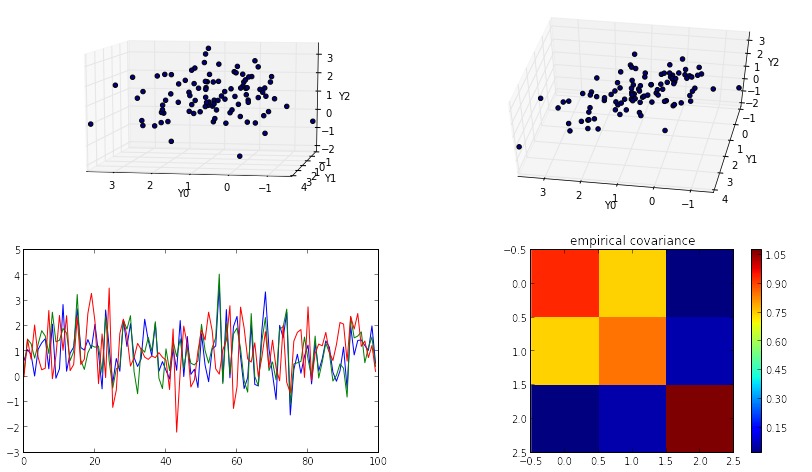

In [315]:
u = np.ones(3)
V = np.array([[1,.8,0],[.8,1,0],[0,0,1]])
Vp = scipy.linalg.inv(V)

Y = np.random.multivariate_normal(u,V,100)
plot_3D_gaussian(Y)
precision_matrix_estimate = scipy.linalg.inv(np.cov(Y.T))
print(precision_matrix_estimate)

### Covariance Matrix vs Precision

Precision matrix has the nice interpretation that If
the ijth component of Σ−1 is zero, then variables i and j are conditionally independent. They represent 'partial correlations'? 


### Graphical Lasso 
Lar's_Path: Computes the least angle regression coefficients as you increase penalty. For plotting that plot in Tibshirani's book. We just use the last coefficient, e.g. (alpha/n_features). **Check if this is = lambda** (but I suppose I doesnt matter too much, as long as I try a broad enough range in my algorithm. 

Method: 3x3

If we are computing the precision for the top row e.g. (X1,X1, X1,X2, X1,X3), we first use the covariances of 
of (X2,X2), (X3,X3), (X2,X3) as a 2x2 matrix to predict part of the top row (X1,X2, X1,X3). It seems like we are trying to explain X1's correlation with the other two, based on the correlation of the other two. Then We set the new precision matrix (first row) to some function of these coefficients. 


### Check whether this is already searching through alphas. 


In [316]:
def graphical_lasso( X, alpha=0.01, max_iter = 100, convg_threshold=0.001 ):
    """ This function computes the graphical lasso algorithm as outlined in Sparse inverse covariance estimation with the
        graphical lasso (2007).
        
    inputs:
        X: the data matrix, size (nxd)
        alpha: the coefficient of penalization, higher values means more sparseness.
        max_iter: maximum number of iterations
        convg_threshold: Stop the algorithm when the duality gap is below a certain threshold.
        
    
    
    """
    
    # no penality just return covariance, and no precision. 
    if alpha == 0:
        return cov_estimator(X)
    
    
    n_features = X.shape[1]
    mle_estimate_ = cov_estimator(X) # estimate covariance 
    covariance_ = mle_estimate_.copy()
    precision_ = np.linalg.pinv( mle_estimate_ ) #pseudo-invert the covariance matrix 
    indices = np.arange( n_features)
    for i in xrange( max_iter):
         
        # loop through each column in the X matrix. 
        for n in range( n_features ):
            
            sub_estimate = covariance_[ indices != n ].T[ indices != n ] # components not related to X of interest
            
            row = mle_estimate_[ n, indices != n] # row for X of interest and all other X's 
            
            
            #solve the lasso problem, predict row of X using all other covariances (not X's)
            _, _, coefs_ = lars_path( sub_estimate, row, Xy = row, Gram = sub_estimate, 
                                        alpha_min = alpha/(n_features-1.), copy_Gram = True,
                                        method = "lars")
            coefs_ = coefs_[:,-1] #just the last please.
            
	    #update the precision matrix. Adjust the top row by multiplying by the coefficients. 
            precision_[n,n] = 1./( covariance_[n,n] 
                                    - np.dot( covariance_[ indices != n, n ], coefs_  ))
            precision_[indices != n, n] = - precision_[n, n] * coefs_
            precision_[n, indices != n] = - precision_[n, n] * coefs_
            temp_coefs = np.dot( sub_estimate, coefs_)
            covariance_[ n, indices != n] = temp_coefs
            covariance_[ indices!=n, n ] = temp_coefs
	    
        #if test_convergence( old_estimate_, new_estimate_, mle_estimate_, convg_threshold):
        if np.abs( _dual_gap( mle_estimate_, precision_, alpha ) )< convg_threshold:
                break
    else:
        #this triggers if not break command occurs
        print "The algorithm did not coverge. Try increasing the max number of iterations."
    
    return covariance_, precision_
        
        
        
        
def cov_estimator( X ):
    return np.cov( X.T) 
    
    
def test_convergence( previous_W, new_W, S, t):
    d = S.shape[0]
    x = np.abs( previous_W - new_W ).mean()
    print x - t*( np.abs(S).sum() + np.abs( S.diagonal() ).sum() )/(d*d-d)
    if np.abs( previous_W - new_W ).mean() < t*( np.abs(S).sum() + np.abs( S.diagonal() ).sum() )/(d*d-d):
        return True
    else:
        return False

def _dual_gap(emp_cov, precision_, alpha):
    """Expression of the dual gap convergence criterion
    The specific definition is given in Duchi "Projected Subgradient Methods
    for Learning Sparse Gaussians".
    """
    gap = np.sum(emp_cov * precision_)
    gap -= precision_.shape[0]
    gap += alpha * (np.abs(precision_).sum()
                    - np.abs(np.diag(precision_)).sum())
    return gap 

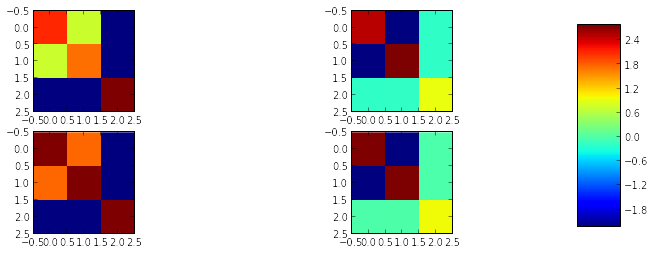

In [317]:
# Estimate Covariance and Precision
covariance, precision = graphical_lasso(Y,alpha=0.1) # high alpha is more sparseness. 


# Plot 
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,4))
im = axes[0,0].imshow(covariance,interpolation='None')

im = axes[1,0].imshow(V,interpolation='None')
im = axes[0,1].imshow(precision,interpolation='None')
im = axes[1,1].imshow(Vp,interpolation='None')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

### Testing BIC in recovering the best Covariance

### BIC

each partition has its own log-liklihood (summed together afterwards). p is the partition. 
$$ \frac{2}{T} \sum^T_i (tr(Pr_p(y_i-u_p)(y_i-u_p)^T) + log(Pr)) + k log(T) $$

The penalty needs to be something like 

http://arxiv.org/pdf/0909.0934v1.pdf


### Need to figure out BIC better or some other penality 

In [334]:
## Do graphical Lasso 
def graphical_lasso_best_lambda(Y,lamdbas,truth=None):
    ## inputs data, and set of lamdbas.. 
    ## returns sparse estimate for precision matrix. 
    
    T = Y.shape[0]
    p = Y.shape[1]
    k = p*p
    
    diagnols = np.matrix(np.eye(p, dtype=bool))

    BICs = np.empty(len(lambdas))
    precisions = np.empty((Y.shape[1],Y.shape[1],len(lambdas)))
    covs = np.empty((Y.shape[1],Y.shape[1],len(lambdas)))
    
    
    meansquare = np.empty(len(lambdas))
    
    # estimated covariance (XtX) with centered variables. (same as np.cov)
    u = Y.mean(0)
    Y_centered = (Y-np.tile(u,(Y.shape[0],1)))
    S = np.dot(Y_centered.T,Y_centered)/(Y.shape[0]-1)
    
    
    
    for l,lambdaa in enumerate(lambdas): 
        
        # Calculate precision matrix using row-wise coupled lasso regression 
        covs[:,:,l], precisions[:,:,l] = graphical_lasso(Y,alpha=lambdaa)
        
        # calculate BIC 
        ll = np.zeros(T)
        logprec = np.log(scipy.linalg.det(precisions[:,:,l])) # check about det 

        #print(logprec)
            
        BIC = -1.0*logprec + np.trace(precisions[:,:,l]*covs[:,:,l]) #+ 
        #print((lambdaa*np.abs(precisions[:,:,l]))[~diagnols].sum())
        
        #print(np.trace(precisions[:,:,l]*S))
        
        BICs[l] = BIC
        
        if truth is not None:
            meansquare[l] = ((precisions[:,:,l]-truth)**2).sum()
    
    # choose the lambda with lowest BIC 
    best_BIC_loc = np.argmin(BICs)
    best_BIC = BICs[best_BIC_loc]
    best_precision =  precisions[:,:,best_BIC_loc]
    
    # re-estimate covariance forcing 0's to be 0? 
    ### NEED #### 
    
    
    return(best_BIC_loc ,best_BIC,best_precision,BICs,precisions,meansquare)


    


In [332]:
diagnols = np.matrix(np.eye(p, dtype=bool))
np.abs(precisions[:,:,-1])[~diagnols]

array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [329]:
precisions[:,:,-1]

array([[ 0.39402676, -0.        , -0.        ],
       [-0.        ,  1.77316471, -0.        ],
       [-0.        , -0.        ,  2.05301354]])

[[ 3.46153846 -1.53846154 -1.53846154]
 [-1.53846154  3.46153846 -1.53846154]
 [-1.53846154 -1.53846154  3.46153846]]
2.89332439516
[[ 1.14866462 -0.         -0.        ]
 [-0.          0.96884166 -0.        ]
 [-0.         -0.          0.99972966]]


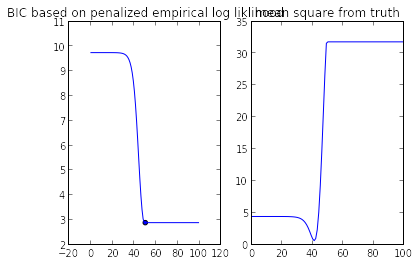

In [352]:
u = np.ones(3)

A = np.random.rand(3,3)

V = np.dot(A,A.transpose())

V = np.array([[1,.8,.8],[.8,1,.8],[.8,.8,1]])
Vp = scipy.linalg.inv(V)
print(Vp)

Y = np.random.multivariate_normal(u,V,100)


lambdas= np.logspace(-8, 8, num=100)
best_BIC_loc,best_BIC,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y,lambdas,Vp)
print(best_BIC)
print(best_precision)


plt.subplot(121)
plt.plot(BICs)
plt.scatter(best_BIC_loc,best_BIC)
plt.title('BIC based on penalized empirical log liklihood')

plt.subplot(122)
plt.plot(meansquare)
plt.title('mean square from truth')

### I feel Like I should Like I should take the inflection point in BIC, when it no longer reduces. 


In [169]:
V

array([[ 1. ,  0.8,  0.8],
       [ 0.8,  1. ,  0.8],
       [ 0.8,  0.8,  1. ]])

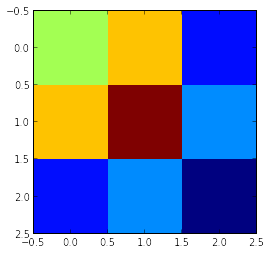

In [296]:
plt.imshow(V,interpolation='None')

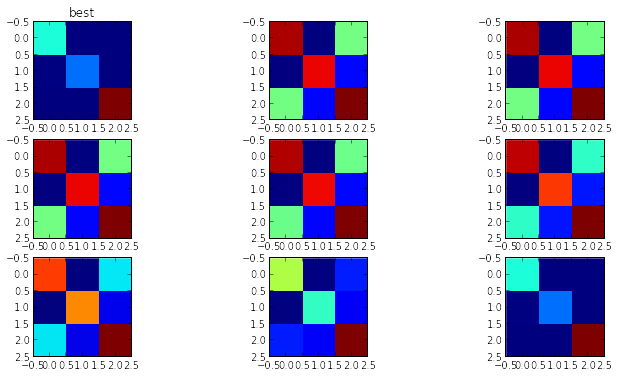

In [295]:
import matplotlib as mpl
index = np.arange(0,len(lambdas),9)


fig, axes = plt.subplots(nrows=3, figsize=(12,6),ncols=3)

for a,ax in enumerate(axes.flat):
    if a ==0:
        im = ax.imshow(best_precision,interpolation='None')
        ax.set_title('best')
    else:
        im = ax.imshow(precisions[:,:,index[a]], interpolation='None')
        
        


## Generating Data with Split Point

$$ Y|X \sim N(u(X),\Sigma(X)) $$


- Two Networks Concatenated, with u(x)=0, Sigma(X) just changes at 100. 
- 

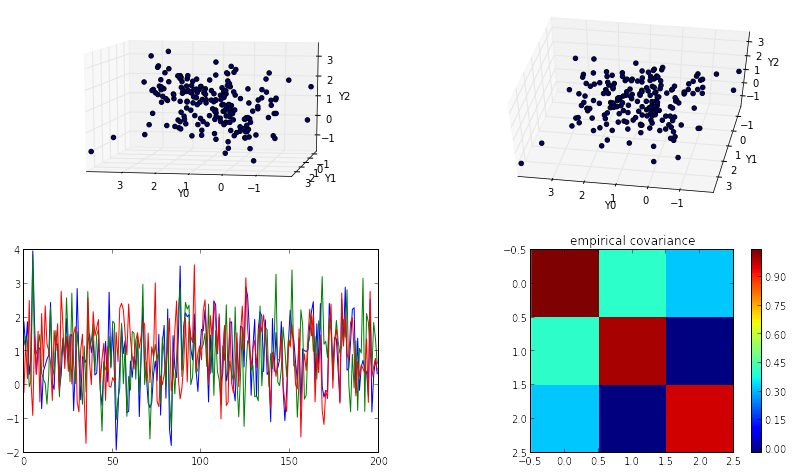

In [361]:
u1 = np.ones(3)
V1 = np.array([[1,.8,0],[.8,1,0],[0,0,1]])
Y1 = np.random.multivariate_normal(u1,V1,100)

u2 = np.ones(3)
V2 = np.array([[1,0,.8],[0,1,0],[.8,0,1]])
Y2 = np.random.multivariate_normal(u2,V2,100)

Y = np.vstack((Y1,Y2))
plot_3D_gaussian(Y)

### Testing BIC in being better with Split Point (and some arbitrary point)
## THIS NEEDS TO WORK BEFORE BELOW WILL WORK

In [356]:
Y.shape

(200, 3)

In [362]:

# BIC on Full Data Set

lambdas= np.logspace(-8, 4, num=100)
best_BIC_loc,best_BIC,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y,lambdas,Vp)
print(best_BIC)

# BIC on True Split Point

best_BIC_loc,best_BIC1,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y1,lambdas,Vp)
best_BIC_loc,best_BIC2,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y2,lambdas,Vp)
best_BICcomb = best_BIC1+best_BIC2
print(best_BICcomb)

# BIC on Fake Split Point



best_BIC_loc,best_BIC1b,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y[0:50,:],lambdas,Vp)
best_BIC_loc,best_BIC2b,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y[51::,:],lambdas,Vp)
best_BICcomb2 = best_BIC1+best_BIC2b
print(best_BICcomb2)

3.01151763407
6.01428021432
6.18427555064


#### Algorithm

1. Estimate mean and covariance on entire time series (no partitions)
    - for covariance estimation, calculate precision matrix then adjust based on full range of lamdbas. Choose the lambda that achieves lowest BIC. Then recalculate Precision matrix with those 0 elements fixed at 0. 
    
2. Go through the data in steps of size $ \uptriangle $ recalculating the covariance matrix for each partition. 
    - store the combined BIC obtained from a split at each time point. 
    - if any splits reduce overall BIC score, keep. And repeat part 2 on the new segments. 
    - stop if BIC is not reduced. 
    
    
    

In [652]:
class vect:

    def __init__(self):
        self.T = 100
        self.partition_store = np.vstack((np.zeros(self.T),np.arange(self.T)))
        self.num_splits=0
        self.split_points = np.array([])
        self.min_step = 10
        
    
    def do_it(self,):
        starting_partition = self.partition_store.copy()
        self.randomsplit(starting_partition)
        
    
    def randomsplit(self,partition):
        
        
        # find the range of places for split point [5,....60-5]
        potential_partition_points = np.arange(self.min_step,partition.shape[1]-self.min_step,1)
        #print(partition[1,:])

        # if array get's smaller than >10 [5,..,5], otherwise don't try to split any more. 
        if potential_partition_points.shape[0]>1:
        
            ###############
            # loop trhough and find the best split # 
            ######
            for potential_partition_point in potential_partition_points:
                split_point = potential_partition_points[np.random.randint(len(potential_partition_points))]
            #print(split_point)
            # [10,..,sp,..60-10]
        
            ##########################
            ### Is this BIC better? 
            ##########
            
            if np.random.randint(100)>1: # if BIC is better keep splitting 

                # increase count of splits 
                self.num_splits+=1 

                # actually make the splits 
                new_part1 = partition[:,0:split_point]
                new_part2 = partition[:,split_point::]
                new_part2[0,:] = self.num_splits

                # store real split point
                self.split_points = np.append(self.split_points,partition[1,split_point])

                # put new partition indexes back into storage
                for i,index in enumerate(new_part2[1,:]):
                    self.partition_store[0,np.int(index)]=new_part2[0,i].copy()


                self.randomsplit(new_part1)
                self.randomsplit(new_part2)
                
            else: # otherwise return 
                #print('BIC not smaller')
                return()
                

        else: # dont' split
            #print('array got too small')
            return()
            
        
        
        
    
    



(array([68, 54, 55, 51, 55, 45, 59, 51, 47, 76]),
 array([ 10. ,  17.9,  25.8,  33.7,  41.6,  49.5,  57.4,  65.3,  73.2,
         81.1,  89. ]),
 <a list of 10 Patch objects>)

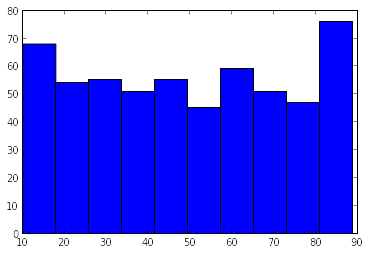

In [655]:
split_points = np.array([])
for i in range(100):
    v = vect()
    v.do_it()
    #print(v.partition_store)
    #print(v.split_points)
    split_points = np.append(split_points,v.split_points)
    
plt.hist(split_points)

In [695]:
class Algorithm:

    def __init__(self,Y):

        self.num_splits=0
        self.split_points = np.array([])
        self.min_step = 10 # minimum size partition
        self.min_step2 = 3 # what to check by 3
        self.Y = Y
        self.T = Y.shape[0]
        self.partition_store = np.vstack((np.zeros(self.T),np.arange(self.T)))
        self.lambdas= np.logspace(-5, 5, num=30)
        
    
    def do_it(self,):
        starting_partition = self.partition_store.copy()
        self.randomsplit(starting_partition)
        
    
    def randomsplit(self,partition):
        
        #####################################################
        ## Calculate Covariance and BIC of full partition ###
        #####################################################
        full_Y = self.Y[partition[1,:].astype('int'),:]
        best_BIC_loc,full_BIC,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(full_Y,self.lambdas)
        print('full_BIC')
        print(full_BIC)
        
        # find the range of places for split point [5,....60-5]
        potential_partition_points = np.arange(self.min_step,partition.shape[1]-self.min_step,1)
        #print('partition')
        #print(partition[1,:])

        # if array get's smaller than >10 [5,..,5], otherwise don't try to split any more. 
        if potential_partition_points.shape[0]>1:
        
            ###############
            # loop trhough and find the best split # 
            ######
            potential_BICS = []
            for potential_partition_point in potential_partition_points[0::self.min_step2]:
                
                # estimate seperate covariances
                Y1 = self.Y[partition[1,0:potential_partition_point].astype('int'),:]
                Y2 = self.Y[partition[1,potential_partition_point::].astype('int'),:]
                
                best_BIC_loc,best_BIC1,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y1,self.lambdas)
                best_BIC_loc,best_BIC2,best_precision,BICs,precisions,meansquare = graphical_lasso_best_lambda(Y2,self.lambdas)

                # combined BIC and store 
                potential_BICS = np.append(potential_BICS,best_BIC1*.5+best_BIC2*.5)
            print('potential BIC')
            print(potential_BICS)
            
            # find minimim BIC
            min_potential_BIC_arg = np.argmin(potential_BICS)
            min_potential_BIC = np.min(potential_BICS)
            split_point = potential_partition_points[min_potential_BIC_arg]

            ##########################
            ### Is this BIC better? 
            ##########
            if min_potential_BIC<full_BIC: # if BIC is better keep splitting 

                # increase count of splits 
                self.num_splits+=1 

                # actually make the splits 
                new_part1 = partition[:,0:split_point]
                new_part2 = partition[:,split_point::]
                new_part2[0,:] = self.num_splits

                # store real split point
                self.split_points = np.append(self.split_points,partition[1,split_point])

                # put new partition indexes back into storage
                for i,index in enumerate(new_part2[1,:]):
                    self.partition_store[0,np.int(index)]=new_part2[0,i].copy()


                self.randomsplit(new_part1)
                self.randomsplit(new_part2)
                
            else: # otherwise return 
                print('BIC not smaller')
                return()
                

        else: # dont' split
            print('array got too small')
            return()
            
        
        
        
    
    



In [696]:
v = Algorithm(Y)
v.do_it()
print(v.partition_store)
print(v.split_points)

full_BIC
3.01151763407
potential BIC
[ 3.1752259   3.24534405  3.13623611  3.04277716  3.03488928  2.96400376
  2.9144209   2.96101371  2.95884905  3.03050419  2.97166008  2.92882442
  2.96123513  2.95691193  2.92807791  3.00982475  3.00211644  3.01640323
  2.98668259  2.97373568  2.98404084  2.99066566  2.98392164  2.98576367
  2.9871167   2.98724731  2.98437858  3.00095453  3.01463615  3.01333034
  3.00714011  3.00986418  3.00806711  3.00254088  2.99682637  3.00001757
  3.00203569  3.00201014  2.99638158  2.95619526  2.9736154   2.95847916
  2.948262    2.96865914  2.97382653  2.98406309  2.98030067  2.99556944
  3.00937787  2.93787742  2.95918257  2.99450593  3.00119396  2.97459956
  2.93263546  2.92591428  3.05806812  2.98079653  2.94175987  2.70760706]
full_BIC
2.90609625525
potential BIC
[ 3.04672815  3.13222483  3.02546289  2.95975778  2.96100894  2.9055757
  2.86446883  2.88098794  2.90397016  2.81292788  2.76581017  2.79818324
  2.86223635  2.76764721  2.54155134  2.46511825  

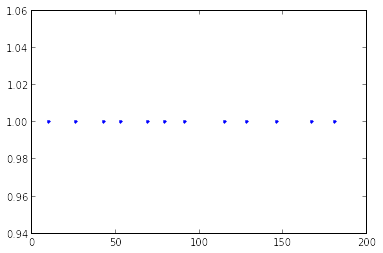

In [700]:
plt.plot(v.split_points,np.ones(len(v.split_points)),linestyle='None',marker='.')